<a href="https://colab.research.google.com/github/Nejmeddin/Phishing-Detection-CNN/blob/main/essai_1_pfa_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install numpy pandas matplotlib seaborn scikit-learn tensorflow

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

In [3]:
from google.colab import files
uploaded = files.upload()

# Chargement du dataset
df = pd.read_csv("dataset_phishing.csv")

Saving dataset_phishing.csv to dataset_phishing (1).csv


In [4]:
# Nettoyage des données
df = df.drop(columns=['url'])  # Suppression de la colonne non pertinente
df['status'] = df['status'].map({'legitimate': 0, 'phishing': 1})

In [5]:
df.shape

(11430, 88)

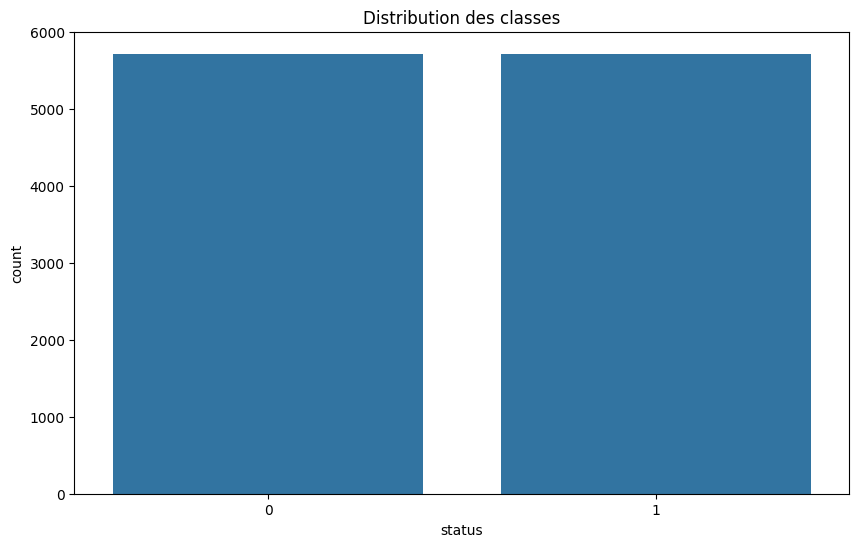

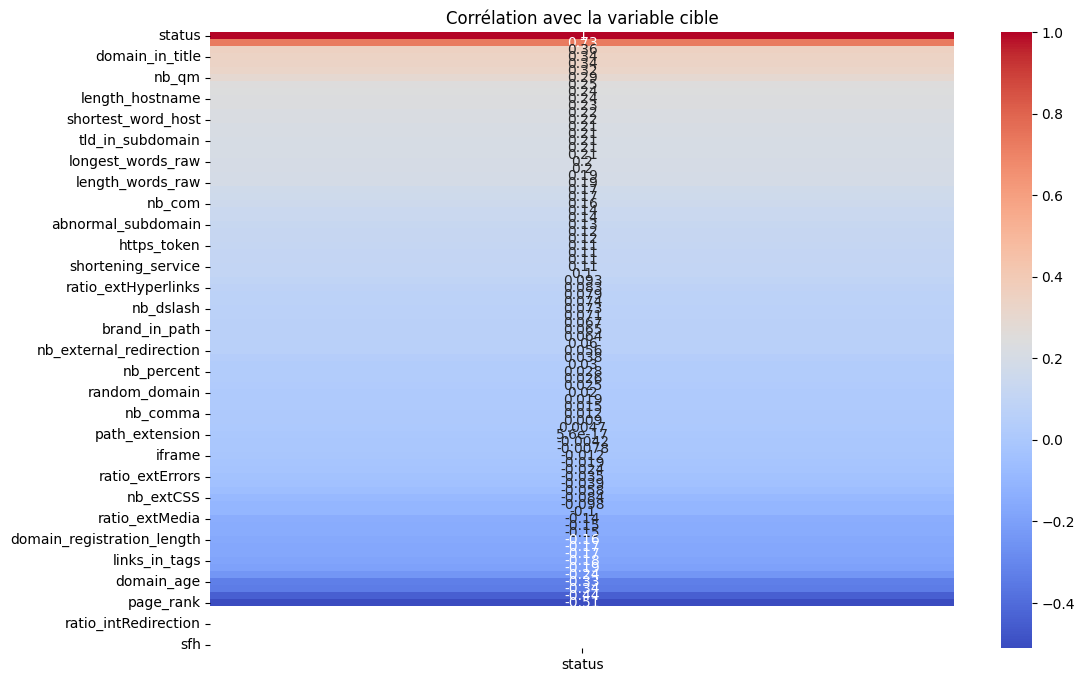

In [6]:
# Étape 2: Analyse exploratoire (EDA)
# ---------------------------------------------------
plt.figure(figsize=(10, 6))
sns.countplot(x='status', data=df)
plt.title('Distribution des classes')
plt.show()

plt.figure(figsize=(12, 8))
sns.heatmap(df.corr()[['status']].sort_values('status', ascending=False),
            annot=True, cmap='coolwarm')
plt.title('Corrélation avec la variable cible')
plt.show()


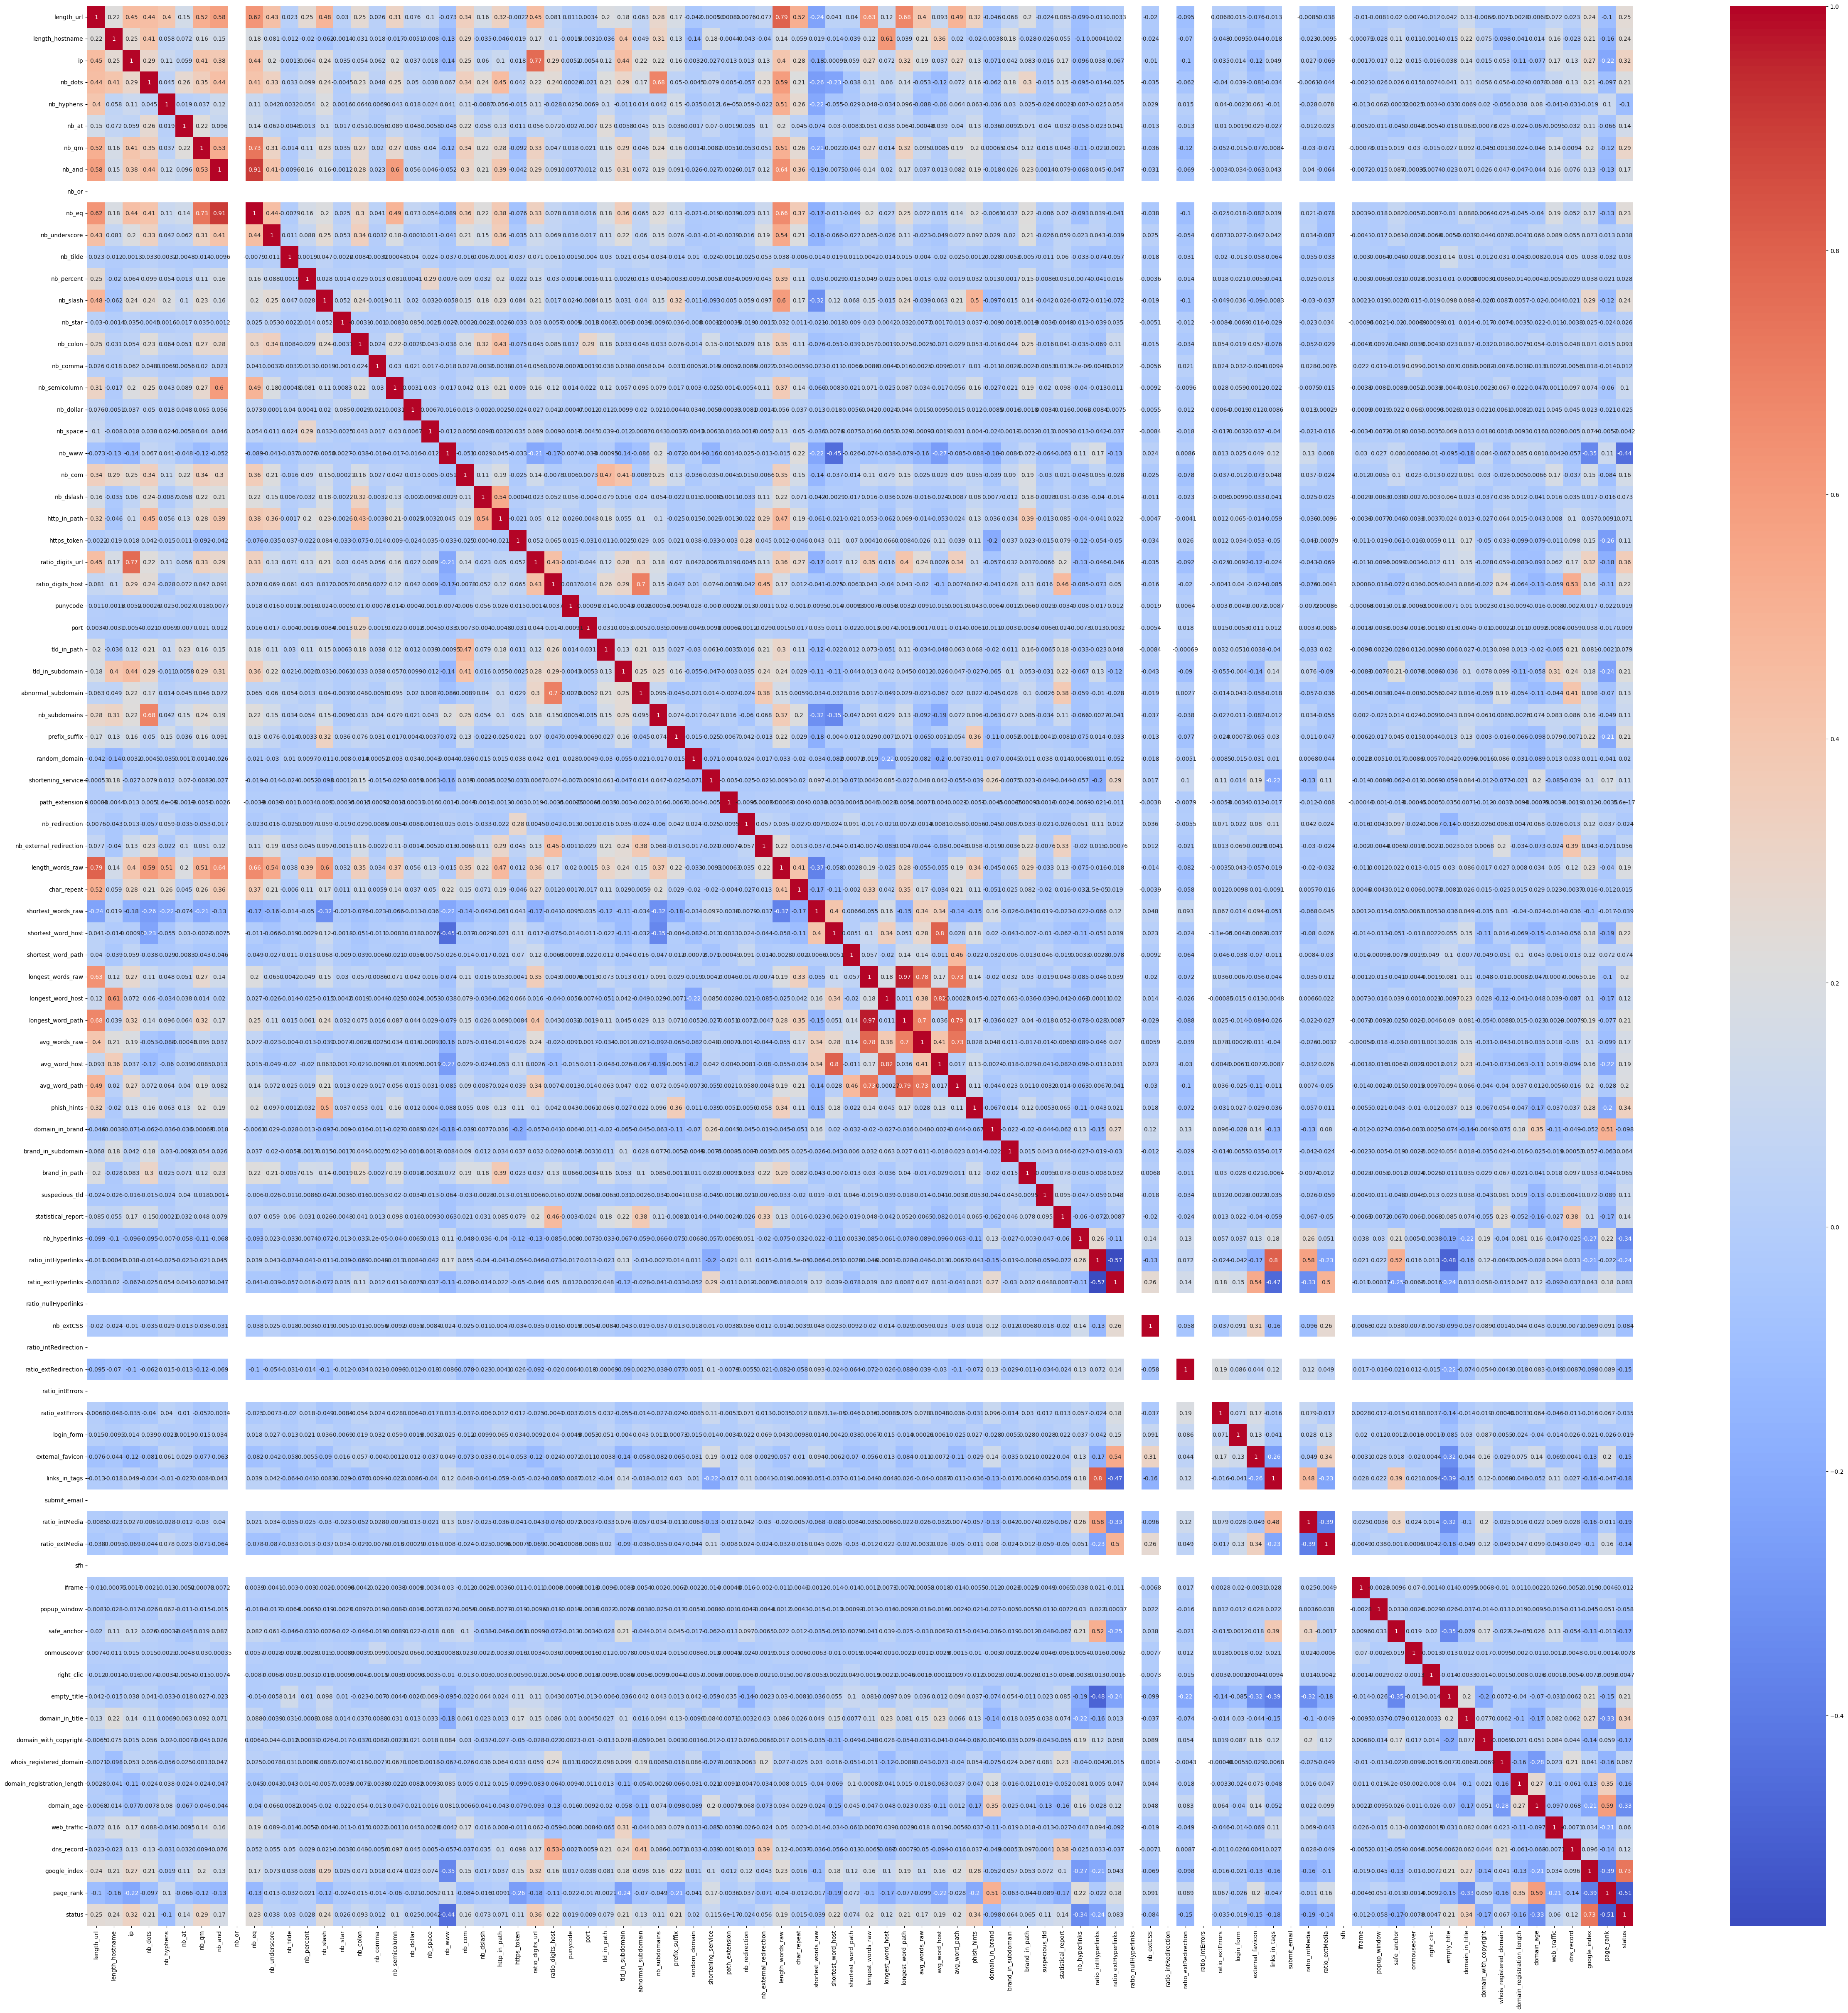

In [20]:
plt.figure(figsize=(60,60))
color = plt.get_cmap('viridis').copy()   # default color
color.set_bad('lightblue')
sns.heatmap(df.corr(),
            annot=True, cmap='coolwarm')
plt.savefig('heatmap')
plt.show()

In [7]:
# Étape 3: Préparation des données pour le CNN
# ---------------------------------------------------
# Séparation features/target
X = df.drop(columns=['status']).values
y = df['status'].values

In [8]:
# Normalisation des données
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [9]:
# Redimensionnement pour CNN 1D
X = X.reshape(X.shape[0], X.shape[1], 1)


In [10]:
# Split des données
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.2,
                                                   random_state=42,
                                                   stratify=y)


In [13]:
import tensorflow as tf


In [11]:
# Étape 4: Architecture du CNN
# ---------------------------------------------------
def build_cnn(input_shape):
    model = Sequential([
        Conv1D(64, 3, activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling1D(2),
        Dropout(0.3),

        Conv1D(128, 3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(2),
        Dropout(0.4),

        Flatten(),

        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),

        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy',
                         tf.keras.metrics.Precision(name='precision'),
                         tf.keras.metrics.Recall(name='recall')])
    return model

In [14]:
# Construction du modèle
model = build_cnn((X_train.shape[1], 1))
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)                    │ (None, 85, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 85, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 42, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 42, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 40, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 40, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 20, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 20, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2560)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         655,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 682,625 (2.60 MB)

 Trainable params: 681,729 (2.60 MB)

 Non-trainable params: 896 (3.50 KB)

In [15]:
# Étape 5: Entraînement avec gestion de l'overfitting
# ---------------------------------------------------
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', save_best_only=True)
]

history = model.fit(X_train, y_train,
                   epochs=100,
                   batch_size=64,
                   validation_split=0.2,
                   callbacks=callbacks,
                   class_weight={0: 1, 1: 1.2})  # Ajustement des poids de classe

Epoch 1/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8198 - loss: 0.4911 - precision: 0.8258 - recall: 0.8176

115/115 ━━━━━━━━━━━━━━━━━━━━ 14s 74ms/step - accuracy: 0.8201 - loss: 0.4902 - precision: 0.8260 - recall: 0.8180 - val_accuracy: 0.6173 - val_loss: 0.6414 - val_precision: 1.0000 - val_recall: 0.2400
Epoch 2/100
114/115 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9026 - loss: 0.2748 - precision: 0.8913 - recall: 0.9147

115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.9026 - loss: 0.2746 - precision: 0.8914 - recall: 0.9148 - val_accuracy: 0.6900 - val_loss: 0.5857 - val_precision: 0.9972 - val_recall: 0.3855
Epoch 3/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9228 - loss: 0.2137 - precision: 0.9132 - recall: 0.9342

115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.9228 - loss: 0.2138 - precision: 0.9132 - recall: 0.9342 - val_accuracy: 0.8650 - val_loss: 0.3027 - val_precision: 0.9884 - val_recall: 0.7405
Epoch 4/100
114/115 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9202 - loss: 0.2273 - precision: 0.9120 - recall: 0.9275

115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9203 - loss: 0.2272 - precision: 0.9121 - recall: 0.9276 - val_accuracy: 0.9404 - val_loss: 0.1719 - val_precision: 0.9699 - val_recall: 0.9099
Epoch 5/100
114/115 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9332 - loss: 0.2020 - precision: 0.9313 - recall: 0.9387

115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.9332 - loss: 0.2020 - precision: 0.9312 - recall: 0.9387 - val_accuracy: 0.9448 - val_loss: 0.1564 - val_precision: 0.9628 - val_recall: 0.9262
Epoch 6/100
114/115 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9409 - loss: 0.1730 - precision: 0.9386 - recall: 0.9435

115/115 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - accuracy: 0.9408 - loss: 0.1731 - precision: 0.9385 - recall: 0.9435 - val_accuracy: 0.9492 - val_loss: 0.1461 - val_precision: 0.9621 - val_recall: 0.9359
Epoch 7/100
114/115 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9390 - loss: 0.1788 - precision: 0.9340 - recall: 0.9454

115/115 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.9391 - loss: 0.1787 - precision: 0.9341 - recall: 0.9454 - val_accuracy: 0.9524 - val_loss: 0.1362 - val_precision: 0.9513 - val_recall: 0.9544
Epoch 8/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.9482 - loss: 0.1520 - precision: 0.9424 - recall: 0.9533 - val_accuracy: 0.9492 - val_loss: 0.1371 - val_precision: 0.9452 - val_recall: 0.9544
Epoch 9/100
114/115 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9493 - loss: 0.1530 - precision: 0.9410 - recall: 0.9580

115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.9493 - loss: 0.1531 - precision: 0.9409 - recall: 0.9579 - val_accuracy: 0.9552 - val_loss: 0.1315 - val_precision: 0.9565 - val_recall: 0.9544
Epoch 10/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.9465 - loss: 0.1487 - precision: 0.9410 - recall: 0.9524 - val_accuracy: 0.9486 - val_loss: 0.1383 - val_precision: 0.9509 - val_recall: 0.9468
Epoch 11/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.9459 - loss: 0.1514 - precision: 0.9350 - recall: 0.9573 - val_accuracy: 0.9492 - val_loss: 0.1341 - val_precision: 0.9442 - val_recall: 0.9555
Epoch 12/100
114/115 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9479 - loss: 0.1450 - precision: 0.9398 - recall: 0.9578

115/115 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.9479 - loss: 0.1451 - precision: 0.9398 - recall: 0.9577 - val_accuracy: 0.9552 - val_loss: 0.1261 - val_precision: 0.9635 - val_recall: 0.9468
Epoch 13/100
114/115 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9556 - loss: 0.1327 - precision: 0.9563 - recall: 0.9556

115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - accuracy: 0.9555 - loss: 0.1328 - precision: 0.9562 - recall: 0.9555 - val_accuracy: 0.9535 - val_loss: 0.1231 - val_precision: 0.9553 - val_recall: 0.9522
Epoch 14/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.9483 - loss: 0.1432 - precision: 0.9354 - recall: 0.9607 - val_accuracy: 0.9524 - val_loss: 0.1309 - val_precision: 0.9513 - val_recall: 0.9544
Epoch 15/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - accuracy: 0.9551 - loss: 0.1264 - precision: 0.9505 - recall: 0.9605 - val_accuracy: 0.9513 - val_loss: 0.1296 - val_precision: 0.9454 - val_recall: 0.9587
Epoch 16/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.9598 - loss: 0.1276 - precision: 0.9515 - recall: 0.9676 - val_accuracy: 0.9513 - val_loss: 0.1317 - val_precision: 0.9571 - val_recall: 0.9457
Epoch 17/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - accuracy: 0.9571 - loss: 0.1247 - precision: 0.9563 - recall: 0.9574 - val_accuracy: 0.9541 - val_loss: 

115/115 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.9582 - loss: 0.1202 - precision: 0.9544 - recall: 0.9621 - val_accuracy: 0.9552 - val_loss: 0.1222 - val_precision: 0.9525 - val_recall: 0.9587
Epoch 20/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.9628 - loss: 0.1088 - precision: 0.9566 - recall: 0.9702 - val_accuracy: 0.9584 - val_loss: 0.1313 - val_precision: 0.9658 - val_recall: 0.9511
Epoch 21/100
114/115 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9600 - loss: 0.1165 - precision: 0.9567 - recall: 0.9623

115/115 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - accuracy: 0.9600 - loss: 0.1164 - precision: 0.9567 - recall: 0.9624 - val_accuracy: 0.9535 - val_loss: 0.1219 - val_precision: 0.9543 - val_recall: 0.9533
Epoch 22/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.9679 - loss: 0.0997 - precision: 0.9635 - recall: 0.9730 - val_accuracy: 0.9546 - val_loss: 0.1253 - val_precision: 0.9645 - val_recall: 0.9446
Epoch 23/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9608 - loss: 0.1055 - precision: 0.9596 - recall: 0.9621 - val_accuracy: 0.9552 - val_loss: 0.1239 - val_precision: 0.9605 - val_recall: 0.9501
Epoch 24/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.9595 - loss: 0.1160 - precision: 0.9588 - recall: 0.9612 - val_accuracy: 0.9557 - val_loss: 0.1235 - val_precision: 0.9646 - val_recall: 0.9468
Epoch 25/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - accuracy: 0.9662 - loss: 0.1035 - precision: 0.9629 - recall: 0.9699 - val_accuracy: 0.9557 - val_loss

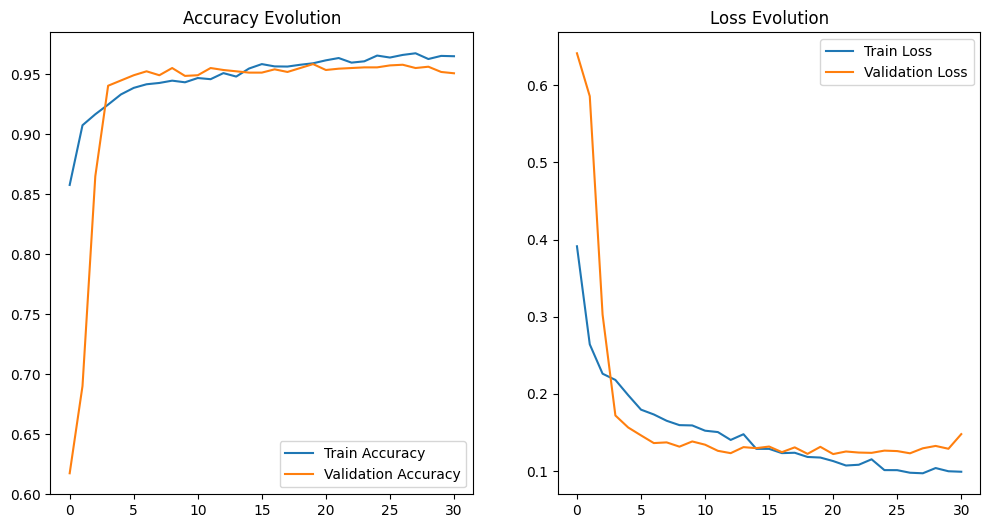

In [16]:
# Étape 6: Évaluation du modèle
# ---------------------------------------------------
# Courbes d'apprentissage
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Evolution')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Evolution')
plt.legend()
plt.show()

In [17]:
# Évaluation finale
y_pred = (model.predict(X_test) > 0.5).astype(int)
print(classification_report(y_test, y_pred))

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1143
           1       0.94      0.96      0.95      1143

    accuracy                           0.95      2286
   macro avg       0.95      0.95      0.95      2286
weighted avg       0.95      0.95      0.95      2286



72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


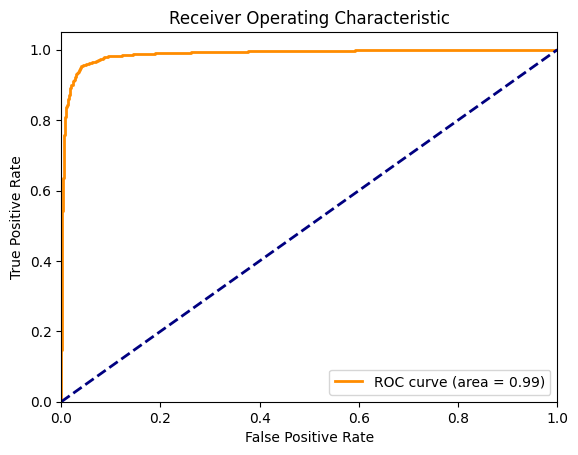

In [18]:
# Courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, model.predict(X_test))
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()